In [23]:
# Импорт библиотек 
import numpy as np 
import pandas as pd 
import scipy 
import seaborn as sns 
import matplotlib.pyplot as plt 

%matplotlib inline

In [3]:
# Импорт данных
df = pd.read_csv('/content/ab_data.csv.zip', compression='zip')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


#Посмотрим на чистоту данных.
Для начала проверим данные на NaN

In [5]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Теперь проверим есть ли пользователи в контрольной группе, которые видели новый сайт и наоборот.

In [8]:
df.groupby(['group', 'landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

Видно, что в данных произошла ошибка и пользователи видели не тот сайт. Удалим ошибочные данные
 

In [9]:
df_clean = df.query('group == "control" and landing_page == "old_page" or group == "treatment" and landing_page == "new_page"')
df_clean.groupby(['group', 'landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


Проверим данные на дубликаты

In [11]:
df_clean.user_id.duplicated().sum()

1

Посмотрим, на них чуть подробнее

In [12]:
df_clean.loc[df_clean.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [19]:
df_clean.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Судя по всему, пользователь видел сайт 2 раза и оба раза конверсии не было. Для простоты будем учитывать только первые действия пользователей.

In [20]:
df_clean = df_clean.drop_duplicates(subset='user_id', keep="first")

#Визуализируем наши данные

Посмотрим на долю конверсий в каждой группе

<Axes: xlabel='group', ylabel='count'>

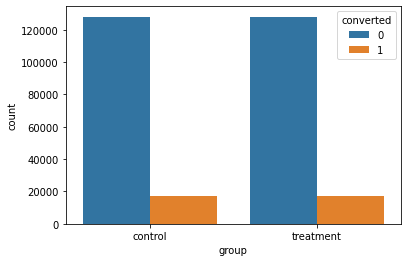

In [27]:
sns.countplot(data=df_clean, x ='group', hue='converted' )

Визуально коэфиценты конверсий выглядят одинаковыми и примерно равны 1/7, но на их разницу мы посмотрим точнее с помощью критерия хи-квадрат


Посмотрим на соотношение пользователей в группах, оно должно быть одинаковым

<Axes: ylabel='landing_page'>

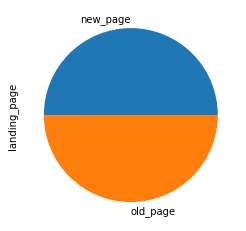

In [30]:
df_clean['landing_page'].value_counts().plot.pie()

#Критерий хи-квадрат


In [31]:
### Переупорядочить данные в 2x2 для хи-квадрат
# 1) Разделим группы на два отдельных кадра данных 
a = df_clean[df_clean['group'] == 'control'] 
b = df_clean[df_clean['group'] == 'treatment']
# 2) A-клик, A-без клика, B-клик, B-без клика 
a_click = a.converted.sum() 
a_noclick = a.converted.size - a.converted.sum() 
b_click = b.converted.sum( ) 
b_noclick = b.converted.size - b.converted.sum()
# 3) Создим массив np 
T = np.array([[a_click, a_noclick], [b_click, b_noclick]])

In [35]:
scipy.stats.chi2_contingency(T,correction=False)[1]

0.18988337448194853

Расчетное значение p равно 19%. Предполагая уровень значимости 5%, мы можем сделать вывод, что мы не отвергаем нулевую гипотезу. Проще говоря, конверсии между старой и новой веб-страницей не имеют значения.

В качестве проверки рассчитаем коэфиценты конверсии у 2 групп. Как можно заметить, разница между ними минимальна

In [36]:
# Проверка работоспособности 
a_CTR = a_click / (a_click + a_noclick) 
b_CTR = b_click / (b_click + b_noclick) 
print(a_CTR, b_CTR)

0.1203863045004612 0.11880806551510564
